In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Estimate the variance factors for the linear mixed-effects models

In [129]:
src = "../data"
dst = "../results/variance_components"
Path(dst).mkdir(parents=True, exist_ok=True)

## Incumbent analysis

In [130]:
fname = "pilot_data1.csv.gzip"
pilot_data1 = pd.read_csv(
    Path(src, fname),
    compression="gzip",
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"]
)

### Estimate variance factors

In [131]:
model = smf.mixedlm(
    "avg_belief_score ~ 1 + PARTY * INCUMBENT", 
    pilot_data1, 
    groups=pilot_data1["author_id"],
)
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: avg_belief_score
No. Observations:  83233   Method:             REML            
No. Groups:        850     Scale:              0.0124          
Min. group size:   1       Log-Likelihood:     63693.8463      
Max. group size:   3432    Converged:          Yes             
Mean group size:   97.9                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.003    0.003  0.856 0.392 -0.004  0.009
PARTY[T.R]           -0.013    0.004 -2.919 0.004 -0.021 -0.004
INCUMBENT            -0.004    0.006 -0.801 0.423 -0.015  0.006
PARTY[T.R]:INCUMBENT  0.009    0.008  1.104 0.269 -0.007  0.026
Group Var             0.002    0.001                           



/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [132]:
result.cov_re

,Group
Group,0.002291


In [133]:
result.scale

0.012392493861011449

In [135]:
fname = "variance_components_incumbent_analysis_belief_speaking.txt"
with open(Path(dst, fname), "w") as outfile:
    outfile.write("var_intercept={}\n".format(result.cov_re["Group"]["Group"]))
    outfile.write("var_residual={}".format(result.scale))

### Estimate confidence interval of random intercept variance

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [8]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [9]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [10]:
likelihood_cuttoff

63691.92627970052

In [11]:
likev[:, 0][first_index]

0.0020530139615529503

In [12]:
likev[:, 0][second_index]

0.0025887228967450076

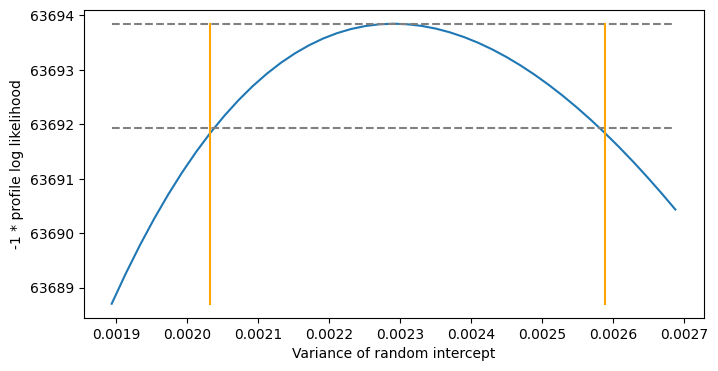

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance

In [ ]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
        pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_belief_score ~ 1 + PARTY * T", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)

In [128]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.00989173, 0.015717  ])

## Vote percent analysis

In [136]:
fname = "pilot_data1.csv.gzip"
pilot_data1 = pd.read_csv(
    Path(src, fname),
    compression="gzip",
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"]
)

In [137]:
# remove all candidates that don't have a vote share
pilot_data1 = pilot_data1.dropna(subset=["VOTE_SHARE"])

# remove all candidates that got a vote share of 100%
pilot_data1 = pilot_data1[pilot_data1["VOTE_SHARE"] != 100]

In [138]:
len(pilot_data1)

51466

In [139]:
len(pilot_data1["author_id"].unique())

571

In [140]:
pilot_data1.drop_duplicates(subset=["author_id"])["PARTY"].value_counts()

PARTY
R    309
D    262
Name: count, dtype: int64

### Estimate variance factors

In [141]:
model = smf.mixedlm(
    "avg_belief_score ~ 1 + PARTY * VOTE_SHARE", 
    pilot_data1, 
    groups=pilot_data1["author_id"],
)
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: avg_belief_score
No. Observations:   51466   Method:             REML            
No. Groups:         571     Scale:              0.0133          
Min. group size:    1       Log-Likelihood:     37521.6338      
Max. group size:    1568    Converged:          Yes             
Mean group size:    90.1                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.001    0.005  0.221 0.825 -0.009  0.011
PARTY[T.R]            -0.011    0.007 -1.508 0.132 -0.025  0.003
VOTE_SHARE             0.000    0.000  0.105 0.917 -0.000  0.000
PARTY[T.R]:VOTE_SHARE -0.000    0.000 -0.035 0.972 -0.000  0.000
Group Var              0.002    0.001                           



/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [142]:
result.cov_re

,Group
Group,0.00196


In [143]:
result.scale

0.013318093681196104

In [144]:
fname = "variance_components_vote_percent_analysis_belief_speaking.txt"
with open(Path(dst, fname), "w") as outfile:
    outfile.write("var_intercept={}\n".format(result.cov_re["Group"]["Group"]))
    outfile.write("var_residual={}".format(result.scale))

### Estimate confidence interval of random intercept variance

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [152]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [153]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [154]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [155]:
likelihood_cuttoff

37506.92396988608

In [156]:
likev[:, 0][first_index]

0.0017093953832548999

In [157]:
likev[:, 0][second_index]

0.002284550428498427

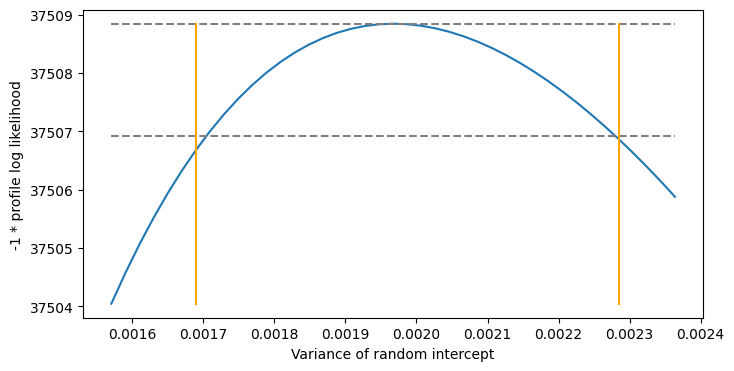

In [158]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance

In [ ]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
        pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_belief_score ~ 1 + PARTY * VOTE_SHARE", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)

In [162]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.00988619, 0.01754056])

## Election analysis

In [120]:
fname = "pilot_data1.csv.gzip"
pilot_data1 = pd.read_csv(
    Path(src, fname),
    compression="gzip",
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"]
)

fname = "pilot_data2.csv.gzip"
pilot_data2 = pd.read_csv(
    Path(src, fname),
    compression="gzip",
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"]
)

pilot_data1["E"] = 0 # tweets from before elections 
pilot_data2["E"] = 1 # tweets from after elections
pilot_data = pd.concat([pilot_data1, pilot_data2]).reset_index(drop=True)

### Estimate variance factors for belief-speaking

In [121]:
model = smf.mixedlm(
    "avg_belief_score ~ 1 + PARTY * E", 
    pilot_data, 
    groups=pilot_data["author_id"],
    re_formula="1 + E"
)
result = model.fit()
print(result.summary())

/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_belief_score
No. Observations: 278007  Method:             REML            
No. Groups:       1026    Scale:              0.0119          
Min. group size:  1       Log-Likelihood:     219162.9529     
Max. group size:  6467    Converged:          Yes             
Mean group size:  271.0                                       
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept       -0.001     0.003  -0.549  0.583  -0.007   0.004
PARTY[T.R]      -0.008     0.004  -2.312  0.021  -0.016  -0.001
E               -0.008     0.002  -3.296  0.001  -0.013  -0.003
PARTY[T.R]:E     0.006     0.003   1.771  0.076  -0.001   0.013
Group Var        0.003     0.001                               
Group x E Cov   -0.000     0.001                            

In [122]:
result.cov_re

,Group,E
Group,0.002526,-0.000193
E,-0.000193,0.001491


In [123]:
result.scale

0.011919028172987234

In [124]:
fname = "variance_components_election_analysis_belief_speaking.txt"
with open(Path(dst, fname), "w") as outfile:
    outfile.write("var_intercept={}\n".format(result.cov_re["Group"]["Group"]))
    outfile.write("var_slope_E={}\n".format(result.cov_re["E"]["E"]))
    outfile.write("cov_intercept_slope_E={}\n".format(result.cov_re["Group"]["E"]))
    outfile.write("var_residual={}".format(result.scale))

### Estimate confidence interval of random intercept variance for belief-speaking

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [75]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [76]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [77]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [78]:
likelihood_cuttoff

219161.0329419397

In [79]:
likev[:, 0][first_index]

0.0022468649250240685

In [80]:
likev[:, 0][second_index]

0.0028654003476021182

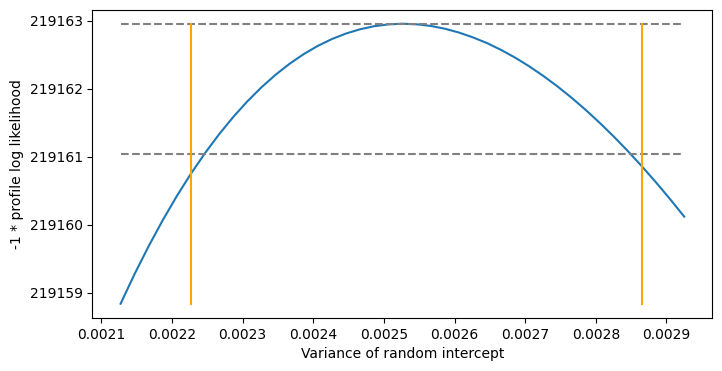

In [81]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of random slope variance for belief-speaking

In [82]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(1, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [83]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [84]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [85]:
likelihood_cuttoff

219161.0329419397

In [86]:
likev[:, 0][first_index]

0.001271560660756135

In [87]:
likev[:, 0][second_index]

0.001770797435051563

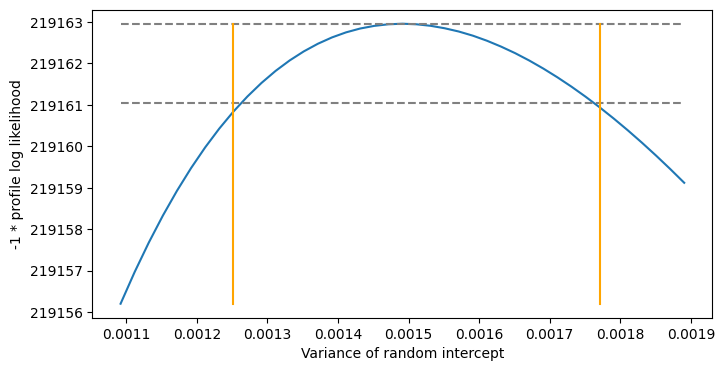

In [88]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance and slope/intercept covariance for belief-speaking

In [89]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
covariances = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
    
    pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_belief_score ~ 1 + PARTY * E", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
        re_formula="1 + E"
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)
    covariances.append(result_bootstrapped.cov_re.loc["Group", "E"])

0


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


1


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


2


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


3


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


4


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


5


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


6


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


7


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


8


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


9


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


10


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


11


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


12


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


13


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


14


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


15


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


16


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


17


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


18


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


19


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


20


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


21


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


22


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


23


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


24


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


25


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


26


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


27


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


28


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


29


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


30


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


31


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


32


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


33


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


34


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


35


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


36


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


37


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


38


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


39


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


40


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


41


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


42


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


43


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


44


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


45


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


46


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


47


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


48


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


49


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


50


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


51


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


52


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


53


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


54


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


55


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


56


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


57


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


58


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


59


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


60


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


61


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


62


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


63


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


64


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


65


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: Convergenc

66


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


67


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


68


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


69


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


70


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


71


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


72


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: Convergenc

73


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


74


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


75


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


76


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


77


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


78


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


79


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


80


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


81


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


82


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


83


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


84


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


85


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


86


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


87


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


88


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


89


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


90


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


91


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


92


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


93


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


94


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


95


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


96


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


97


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/base/model.py:607: Convergenc

98


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


99


/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [90]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.0100747 , 0.01413184])

In [91]:
np.percentile(covariances, [2.5, 97.5])

array([-0.00087321,  0.0017843 ])

### Estimate variance factors for fact-speaking

In [125]:
model = smf.mixedlm(
    "avg_fact_score ~ 1 + PARTY * E", 
    pilot_data, 
    groups=pilot_data["author_id"],
    re_formula="1 + E"
)
result = model.fit()
print(result.summary())

/home/jana/python_environments/default/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: avg_fact_score
No. Observations: 278007  Method:             REML          
No. Groups:       1026    Scale:              0.0094        
Min. group size:  1       Log-Likelihood:     251745.8889   
Max. group size:  6467    Converged:          Yes           
Mean group size:  271.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.006    0.002  2.825 0.005  0.002  0.011
PARTY[T.R]        -0.013    0.003 -4.236 0.000 -0.019 -0.007
E                 -0.007    0.002 -3.454 0.001 -0.012 -0.003
PARTY[T.R]:E       0.008    0.003  2.703 0.007  0.002  0.014
Group Var          0.002    0.001                           
Group x E Cov     -0.000    0.001                           
E Var              0.001    0.001   

In [126]:
result.cov_re

,Group,E
Group,0.001825,-0.000104
E,-0.000104,0.001133


In [127]:
result.scale

0.009431259596607152

In [128]:
fname = "variance_components_election_analysis_fact_speaking.txt"
with open(Path(dst, fname), "w") as outfile:
    outfile.write("var_intercept={}\n".format(result.cov_re["Group"]["Group"]))
    outfile.write("var_slope_E={}\n".format(result.cov_re["E"]["E"]))
    outfile.write("cov_intercept_slope_E={}\n".format(result.cov_re["Group"]["E"]))
    outfile.write("var_residual={}".format(result.scale))

### Estimate confidence interval of random intercept variance for fact-speaking

Following this [tutorial](https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html) and this [explanation](https://strimmerlab.github.io/publications/lecture-notes/MATH20802/likelihood-based-confidence-interval-and-likelihood-ratio.html) of likelihood-based CIs.

In [95]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(0, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [96]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [97]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [98]:
likelihood_cuttoff

251743.9688749131

In [99]:
likev[:, 0][first_index]

0.0016253111396092499

In [100]:
likev[:, 0][second_index]

0.0020642941596522146

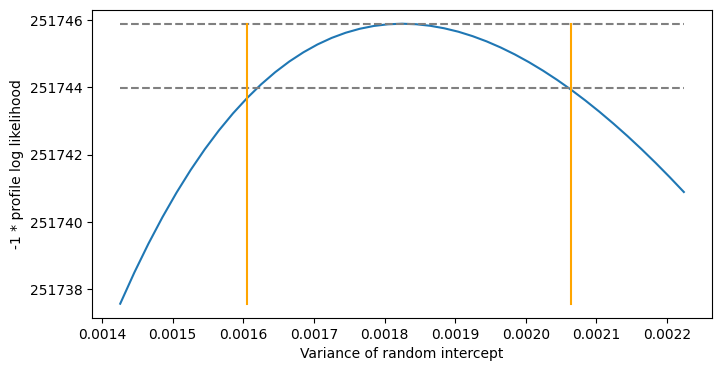

In [101]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of random slope variance for fact-speaking

In [102]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = result.profile_re(1, vtype='re', dist_low=0.0004, dist_high=0.0004, num_low=20, num_high=20)

In [103]:
likelihood_cuttoff = likev[:, 1].max() - 1.92

In [104]:
first_index = np.argmax(likev[:, 1] > likelihood_cuttoff)
second_index = np.argmax(likev[first_index:, 1] < likelihood_cuttoff) + first_index

In [105]:
likelihood_cuttoff

251743.9688749131

In [106]:
likev[:, 0][first_index]

0.0009734652721768921

In [107]:
likev[:, 0][second_index]

0.001352890648267859

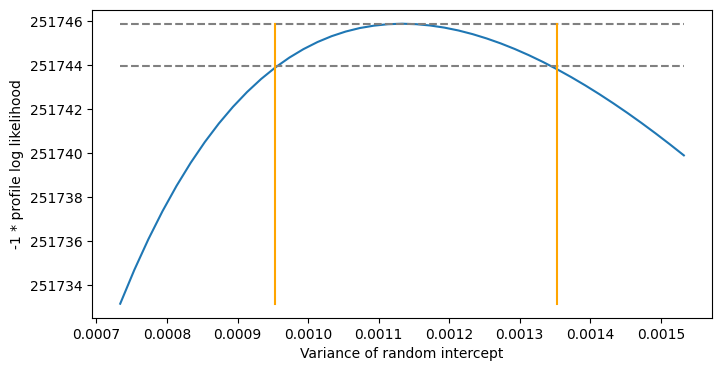

In [108]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(likev[:, 0], likev[:, 1])
ax.set_xlabel("Variance of random intercept")
ax.set_ylabel("-1 * profile log likelihood")
ax.ticklabel_format(useOffset=False)

ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likev[:, 1].max(), likev[:, 1].max()], "--", color="grey")
ax.plot([likev[:, 0].min(), likev[:, 0].max()], [likelihood_cuttoff, likelihood_cuttoff], "--", color="grey")
ax.plot([likev[:, 0][first_index - 1], likev[:, 0][first_index - 1]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")
ax.plot([likev[:, 0][second_index], likev[:, 0][second_index]], [likev[:, 1].min(), likev[:, 1].max()], color="orange")

### Estimate confidence interval of residual variance and slope/intercept covariance for fact-speaking

In [ ]:
# via bootstrapping on authors
n_bootstrap = 100

scale_vals = []
covariances = []
for n in range(n_bootstrap):
    print(n)
    pilot_data_bootstrapped = pd.DataFrame()
    for i in range(len(pilot_data["author_id"].unique())):
        
        # sample an author id and get the candidate's tweets
        candidate = np.random.choice(pilot_data["author_id"].unique(), 1)[0]
        candidate_tweets = pilot_data[pilot_data["author_id"] == candidate]

        # add the tweets to the bootstrapped data set
        pilot_data_bootstrapped = pd.concat([pilot_data_bootstrapped, candidate_tweets])
    
    pilot_data_bootstrapped = pilot_data_bootstrapped.reset_index(drop=True)

    # fit the lme on the bootstrapped data
    model_bootstrapped = smf.mixedlm(
        "avg_fact_score ~ 1 + PARTY * E", 
        pilot_data_bootstrapped, 
        groups=pilot_data_bootstrapped["author_id"],
        re_formula="1 + E"
    )
    result_bootstrapped = model_bootstrapped.fit()
    scale_vals.append(result_bootstrapped.scale)
    covariances.append(result_bootstrapped.cov_re.loc["Group", "E"])

In [110]:
np.percentile(scale_vals, [2.5, 97.5])

array([0.00795373, 0.01124389])

In [111]:
np.percentile(covariances, [2.5, 97.5])

array([-0.00056843,  0.00017699])